In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
np.seterr(over="raise")
import matplotlib.pyplot as plt

import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

zcross = lambda A: d3.MulCosine(d3.skew(A))
from mydedalustools import *

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


In [2]:
from scipy.integrate import cumtrapz
def ZH_zetaa_u(lat,lat0,alpha):
    f = 2*Omega*np.sin(lat)
    alpha2 = 1/np.cos(lat0)**2-alpha*np.tan(lat0)**2
    dlat = 5*np.pi/180
    step = lambda x: (np.tanh(-x)+1)/2
    zetaa = alpha * f * step((np.abs(lat)-lat0)/dlat) + alpha2 * f * step((-np.abs(lat)+lat0)/dlat)
    u = -cumtrapz(R*(zetaa-f)*np.cos(lat),lat,initial=0)/np.cos(lat)
    return zetaa,u

In [75]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24
Kelvin = 1

# Earth parameters
R_E = 6.4e6*meter
Omega_E = 2*np.pi/86400 / second
Omega = Omega_E
R = R_E

# Set Parameters
Ro_T = 10.
E = 0.02
tau_rad_nondim = 200
mu = 0.05

# diagnostic parameters
cp = 1004 * meter**2 / second**2 / Kelvin
P1 = 0.25**(0.286)
P2 = 0.75**(0.286)

DeltaTheta = Ro_T*(2*Omega*R)**2/cp
DeltaThetaVertical = mu*DeltaTheta
taurad = tau_rad_nondim/(2*Omega)
taudrag = 1/(2*Omega*E)


Now let's build two bases for the sphere. First, one to just represent zonally constant fields, and second, one to represent full 2D fields on the sphere:

In [62]:
Nphi = 128; Ntheta = 64#; hyperdiff_degree = 8; nu = 10*3e37*meter**8/second 
#Nphi = 64; Ntheta = 32; hyperdiff_degree = 8; nu = 100*3e37*meter**8/second 

hyperdiff_degree=4; nu = 10*40e15*meter**4/second * (R/R_E)**4 * (Omega/Omega_E)


dealias = (3/2, 3/2)
dtype = np.complex128

# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)
zonal_basis = d3.SphereBasis(coords, (1, Ntheta), radius=R, dealias=dealias, dtype=dtype)

# Constructing an axisymmetric basic state

In [5]:
snapshots_2level_T21_axi = open_h5s_wgauge('snapshots_2levelnew_T21_axi_10_p02_200_p05', ('s4',))


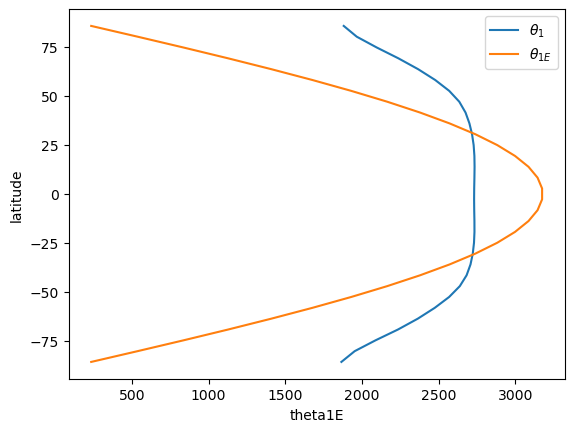

In [6]:
(snapshots_2level_T21_axi.theta1 ).mean(('t','longitude')).plot(y='latitude',label=r"$\theta_1$")
(snapshots_2level_T21_axi.theta1E).mean(('t','longitude')).plot(y='latitude',label=r"$\theta_{1E}$")
plt.legend()

In [ ]:
### DOES NOT CONVERGE

lat_forcing = lambda lat: np.cos(lat)
lon_forcing = lambda lon: 1/np.pi*lon**0

#hyperdiff_degree=4; nu = 1e4*40e15*meter**4/second * (R/R_E)**4 * (Omega/Omega_E)
hyperdiff_degree = 8; nu = 10*1e8*3e37*meter**8/second 

# cross product by zhat
zcross = lambda A: d3.MulCosine(d3.skew(A))

# Fields
u1       = dist.VectorField(coords, name='u1', bases=zonal_basis)
u2       = dist.VectorField(coords, name='u2', bases=zonal_basis)
omega    = dist.Field(name='omega' , bases=zonal_basis)
Phi1     = dist.Field(name='Phi1'  , bases=zonal_basis)
theta1   = dist.Field(name='theta1', bases=zonal_basis)
theta2   = dist.Field(name='theta2', bases=zonal_basis)
theta1E  = dist.Field(name='theta1E', bases=zonal_basis)
theta2E  = dist.Field(name='theta2E', bases=zonal_basis)
tau1 = dist.Field(name='tau1')

phi, theta = dist.local_grids(zonal_basis)
lat = np.pi / 2 - theta + 0*phi
lon = phi-np.pi

theta1E['g'] = DeltaTheta*lat_forcing(lat)*lon_forcing(lon) + DeltaThetaVertical*lat_forcing(lat)
theta2E['g'] = DeltaTheta*lat_forcing(lat)*lon_forcing(lon)

u1    ['g'] = (snapshots_2level_T21_axi.u1     ).mean(('t','longitude')).data[:,None,:]
u2    ['g'] = (snapshots_2level_T21_axi.u2     ).mean(('t','longitude')).data[:,None,:]
omega ['g'] = (snapshots_2level_T21_axi.omega  ).mean(('t','longitude')).data
Phi1  ['g'] = (snapshots_2level_T21_axi.Phi1   ).mean(('t','longitude')).data
theta1['g'] = (snapshots_2level_T21_axi.theta1 ).mean(('t','longitude')).data
theta2['g'] = (snapshots_2level_T21_axi.theta2 ).mean(('t','longitude')).data
if hyperdiff_degree==4:
    diffs = ['nu*lap(lap(%s))'%var for var in ('u1','u2','theta1','theta2')]
elif hyperdiff_degree==8:
    diffs = ['nu*lap(lap(lap(lap(%s))))'%var for var in ('u1','u2','theta1','theta2')]
else:
    raise ValueError('hyperdiff_degree')
    
## Problem
#problem = d3.NLBVP([u1,u2,Phi1,theta1,theta2,tau1], namespace=locals())
#problem.add_equation("%s + grad(Phi1) + 2*Omega*zcross(u1) = - u1@grad(u1) - div(u2)/2*(u2-u1)"%diffs[0])
#problem.add_equation("%s + grad(Phi1- (P2-P1)*cp*(theta1+theta2)/2) + 2*Omega*zcross(u2) + u2/taudrag = - u2@grad(u2) - div(u2)/2*(u2-u1)"%diffs[1])
#problem.add_equation("%s = - div(u1*theta1) - div(u2)/2*(theta2+theta1) + (theta1E-theta1)/taurad"%diffs[2])
#problem.add_equation("%s = - div(u2*theta2) + div(u2)/2*(theta2+theta1) + (theta2E-theta2)/taurad"%diffs[3])
#problem.add_equation("div(u1+u2) + tau1 = 0")
#problem.add_equation("ave(Phi1) = 0")

problem = d3.NLBVP([u1,u2,Phi1,theta1,theta2,tau1], namespace=locals())
problem.add_equation("%s + grad(Phi1) + 2*Omega*zcross(u1) = - u1@grad(u1)"%diffs[0])
problem.add_equation("%s + grad(Phi1- (P2-P1)*cp*(theta1+theta2)/2) + 2*Omega*zcross(u2) + u2/taudrag = - u2@grad(u2)"%diffs[1])
problem.add_equation("%s = - div(u1*theta1) + (theta1E-theta1)/taurad"%diffs[2])
problem.add_equation("%s = - div(u2*theta2) + (theta2E-theta2)/taurad"%diffs[3])
problem.add_equation("div(u1+u2) + tau1 = 0")
problem.add_equation("ave(Phi1) = 0")


ncc_cutoff = 1e-7
tolerance = 6e-3

#u1      .change_scales(dealias)
#u2      .change_scales(dealias)
#omega   .change_scales(dealias)
#Phi1    .change_scales(dealias)
#theta1  .change_scales(dealias)
#theta2  .change_scales(dealias)
#tau1.change_scales(dealias)
#theta1E .change_scales(dealias)
#theta2E .change_scales(dealias)

solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
pert_norm = np.inf

while pert_norm > tolerance:
    solver.newton_iteration(damping=0.1)
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')

u1      .change_scales(1)
u2      .change_scales(1)
omega   .change_scales(1)
Phi1    .change_scales(1)
theta1  .change_scales(1)
theta2  .change_scales(1)
theta1E .change_scales(1)
theta2E .change_scales(1)

Text(0.5, 1.0, 'Zonal-mean zonal wind [u_1]$')

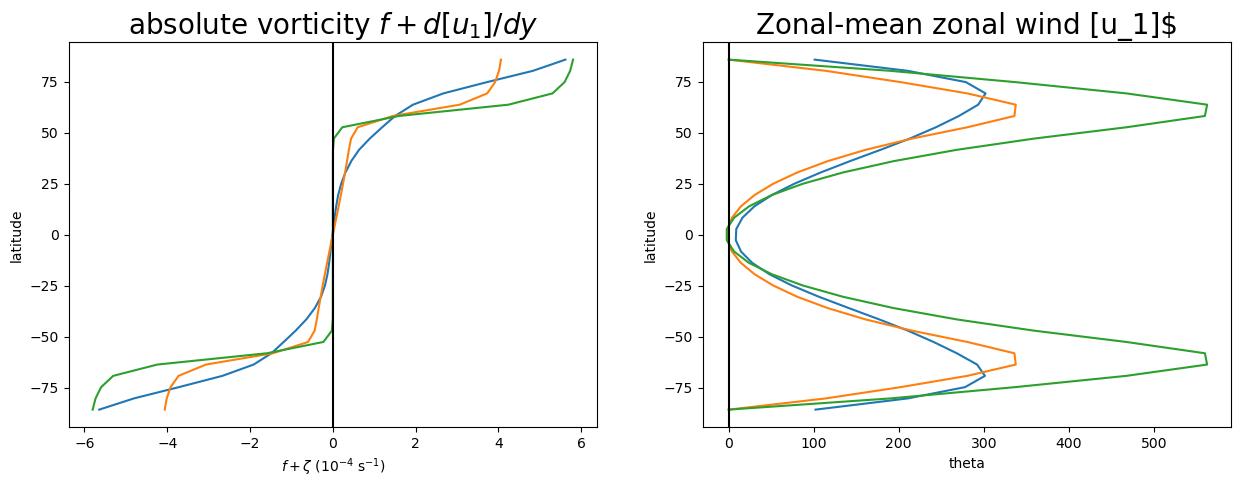

In [7]:
_,axs = plt.subplots(1,2,figsize=(15,5))

((snapshots_2level_T21_axi.vorticity_1 + 2*Omega*np.cos(snapshots_2level_T21_axi.theta))*second*1e4).mean(('t','longitude')).plot(ax=axs[0],y='latitude')
(snapshots_2level_T21_axi.u1[:,0]/(meter/second)).mean(('t','longitude')).plot(ax=axs[1],y='latitude')

zetaa,u = ZH_zetaa_u(np.pi/2 - snapshots_2level_T21_axi.theta,60*np.pi/180,0.4)
(zetaa*second*1e4).plot(ax=axs[0],y='latitude')
(u/(meter/second)).plot(ax=axs[1],y='latitude')

zetaa,u = ZH_zetaa_u(np.pi/2 - snapshots_2level_T21_axi.theta,60*np.pi/180,0.)
(zetaa*second*1e4).plot(ax=axs[0],y='latitude')
(u/(meter/second)).plot(ax=axs[1],y='latitude')


for ax in axs:
    ax.axvline(0.,color='k')
axs[0].set_title(r'absolute vorticity $f+d[u_1]/dy$ ', fontsize=20)
axs[0].set_xlabel(r"$f+\zeta$ $(10^{-4}$ s$^{-1})$")
axs[1].set_title(r'Zonal-mean zonal wind [u_1]$'     , fontsize=20)

# Eigenmodes

In [99]:
######## SETUP PROBLEM ########
# cross product by zhat
zcross = lambda A: d3.MulCosine(d3.skew(A))
if hyperdiff_degree==4:
    hyperdiff = lambda A : nu*d3.lap(d3.lap(A))
elif hyperdiff_degree==8:
    hyperdiff = lambda A : nu*d3.lap(d3.lap(d3.lap(d3.lap(A))))
else:
    raise ValueError('hyperdiff_degree')

# Fields
u10      = dist.VectorField(coords, name='u10', bases=zonal_basis)
u20      = dist.VectorField(coords, name='u20', bases=zonal_basis)
u1       = dist.VectorField(coords, name='u1', bases=full_basis)
u2       = dist.VectorField(coords, name='u2', bases=full_basis)
Phi1     = dist.Field(name='Phi1'  , bases=full_basis)
theta1   = dist.Field(name='theta1', bases=full_basis)
theta2   = dist.Field(name='theta2', bases=full_basis)
Deltatheta0   = dist.Field(name='Deltatheta0', bases=zonal_basis)
tau1 = dist.Field(name='tau1')
sigma = dist.Field(name='sigma')  # eigenvalue


# Problem
problem = d3.EVP([u1,u2,Phi1,theta1,theta2,tau1], eigenvalue=sigma, namespace=locals())
problem.add_equation("sigma*u1 + hyperdiff(u1) + grad(Phi1) + 2*Omega*zcross(u1) + u10@grad(u1) + u1@grad(u10) = 0")
problem.add_equation("sigma*u2 + hyperdiff(u2) + grad(Phi1- (P2-P1)*cp*(theta1+theta2)/2) + 2*Omega*zcross(u2) + u2/taudrag + u20@grad(u2) + u2@grad(u20) = 0")
problem.add_equation("sigma*theta1 + hyperdiff(theta1) + u10@grad(theta1) - div(u2)/2*Deltatheta0 + theta1/taurad = 0")
problem.add_equation("sigma*theta2 + hyperdiff(theta2) + u20@grad(theta2) - div(u2)/2*Deltatheta0 + theta2/taurad = 0")
problem.add_equation("div(u1+u2) + tau1 = 0")
problem.add_equation("ave(Phi1) = 0");

solver = problem.build_solver()

In [100]:
######## INITIALIZE BASIC STATE ########
Deltatheta0['g'] = np.pi/4 * DeltaThetaVertical
phi, theta = dist.local_grids(zonal_basis)
_,u = ZH_zetaa_u(np.pi/2 - theta,50*np.pi/180,0.4)
u10['g'][0] = u.data
u20['g'][0] = u.data

In [101]:
m_max=1
growth_rates = np.zeros(m_max)
frequencies = np.zeros(m_max)
phasespeeds = np.zeros(m_max)
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta[0]) / np.pi * 180
longitude = phi[:,0] / np.pi * 180
skeleton = xr.DataArray(Phi1['g']**0,coords={'latitude':latitude,'longitude':longitude},dims=['longitude','latitude'])
skeletonu = xr.DataArray(u1['g']**0,coords={'latitude':latitude,'longitude':longitude},dims=['component','longitude','latitude'])
modes=[]
for m in range(1,m_max + 1):
    sp = solver.subproblems_by_group[(m, None)]
    solver.solve_dense(sp)
    eigens = solver.eigenvalues.real
    eigens[np.isinf(eigens)] = -1e10
    index = np.argmax(eigens)
    growth_rates[m-1] = eigens[index]
    frequencies[m-1] = -solver.eigenvalues.imag[index]
    phasespeeds[m-1] = frequencies[m-1]/m*R
    solver.set_state(index, sp.subsystems[0])
    Phi1_ = skeleton*Phi1['g']
    Phi2_ = skeleton*(Phi1['g']- (P2-P1)*cp*(theta1['g']+theta2['g'])/2)
    u1_ = skeletonu*u1['g']
    u2_ = skeletonu*u2['g']
    omega = d3.div(u2).evaluate()
    hyperdiff_u1 = hyperdiff(u1).evaluate()
    u1.change_scales(1); u2.change_scales(1); omega.change_scales(1); hyperdiff_u1.change_scales(1)
    omega_ = skeleton*omega['g']
    hyperdiff_u1_ = skeleton*hyperdiff_u1['g'][0]
    ds = xr.merge((u1_.rename('u1'),u2_.rename('u2'),Phi1_.rename('Phi1'),Phi2_.rename('Phi2'),omega_.rename('omega'), hyperdiff_u1_.rename('hyperdiff_u1')))
    modes.append(ds)

2023-08-15 14:08:41,176 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 8.8e-01/s


In [79]:
n_max=10; m=1
growth_rates = np.zeros(n_max)
frequencies  = np.zeros(n_max)
phasespeeds  = np.zeros(n_max)
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta[0]) / np.pi * 180
longitude = phi[:,0] / np.pi * 180
skeleton = xr.DataArray(Phi1['g']**0,coords={'latitude':latitude,'longitude':longitude},dims=['longitude','latitude'])
skeletonu = xr.DataArray(u1['g']**0,coords={'latitude':latitude,'longitude':longitude},dims=['component','longitude','latitude'])
modes=[]

sp = solver.subproblems_by_group[(m, None)]
solver.solve_dense(sp)
eigens = solver.eigenvalues.real
eigens[np.isinf(eigens)] = -1e10

for n in range(1,n_max + 1):
    index = np.argsort(eigens)[-n]
    growth_rates[n-1] = eigens[index]
    frequencies [n-1] = -solver.eigenvalues.imag[index]
    phasespeeds [n-1] = frequencies[n-1]/m*R
    solver.set_state(index, sp.subsystems[0])
    Phi1_ = skeleton*Phi1['g']
    Phi2_ = skeleton*(Phi1['g']- (P2-P1)*cp*(theta1['g']+theta2['g'])/2)
    u1_   = skeletonu*u1['g']
    u2_   = skeletonu*u2['g']
    omega = d3.div(u2).evaluate()
    hyperdiff_u1 = hyperdiff(u1).evaluate()
    u1.change_scales(1); u2.change_scales(1); omega.change_scales(1); hyperdiff_u1.change_scales(1)
    omega_ = skeleton*omega['g']
    hyperdiff_u1_ = skeleton*hyperdiff_u1['g'][0]
    ds = xr.merge((u1_.rename('u1'),u2_.rename('u2'),Phi1_.rename('Phi1'),Phi2_.rename('Phi2'),omega_.rename('omega'), hyperdiff_u1_.rename('hyperdiff_u1')))
    modes.append(ds)

In [30]:
n_max=6; m=1
growth_rates = np.zeros(n_max)
frequencies  = np.zeros(n_max)
phasespeeds  = np.zeros(n_max)
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta[0]) / np.pi * 180
longitude = phi[:,0] / np.pi * 180
skeleton = xr.DataArray(Phi1['g']**0,coords={'latitude':latitude,'longitude':longitude},dims=['longitude','latitude'])
skeletonu = xr.DataArray(u1['g']**0,coords={'latitude':latitude,'longitude':longitude},dims=['component','longitude','latitude'])
modes=[]

sp = solver.subproblems_by_group[(m, None)]
solver.solve_dense(sp)
eigens = solver.eigenvalues.real
eigens[np.isinf(eigens)] = -1e10

n=1
i=1
while n<=n_max:
    index = np.argsort(eigens)[-i]
    growth_rates[n-1] = eigens[index]
    frequencies [n-1] = -solver.eigenvalues.imag[index]
    phasespeeds [n-1] = frequencies[n-1]/m*R
    solver.set_state(index, sp.subsystems[0])
    Phi1_ = skeleton*Phi1['g']
    Phi2_ = skeleton*(Phi1['g']- (P2-P1)*cp*(theta1['g']+theta2['g'])/2)
    u1_   = skeletonu*u1['g']
    u2_   = skeletonu*u2['g']
    omega = d3.div(u2).evaluate()
    hyperdiff_u1 = hyperdiff(u1).evaluate()
    u1.change_scales(1); u2.change_scales(1); omega.change_scales(1); hyperdiff_u1.change_scales(1)
    omega_ = skeleton*omega['g']
    hyperdiff_u1_ = skeleton*hyperdiff_u1['g'][0]
    ds = xr.merge((u1_.rename('u1'),u2_.rename('u2'),Phi1_.rename('Phi1'),Phi2_.rename('Phi2'),omega_.rename('omega'), hyperdiff_u1_.rename('hyperdiff_u1')))
    modes.append(ds)
    if np.abs(phasespeeds[n-1])<10*meter/second:
        n+=1
    i+=1

In [28]:
def multiply_clean(ds1,ds2,Radius,Ntheta=64,Nphi=128):
    dealias=(3/2,3/2);dtype = np.float64
    coords = d3.S2Coordinates('phi', 'theta')
    dist = d3.Distributor(coords, dtype=dtype)#
    full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=Radius, dealias=dealias, dtype=dtype)
    a  = dist.Field(name='a', bases=full_basis)
    b  = dist.Field(name='b', bases=full_basis)
    a['g'] = ds1
    b['g'] = ds2
    c = (a*b).evaluate(); c.change_scales(1)
    return c['g']*ds1**0

def divergence_clean(ds,Radius,Ntheta=64):
    dealias=(3/2,3/2);dtype = np.float64
    coords = d3.S2Coordinates('phi', 'theta')
    dist = d3.Distributor(coords, dtype=dtype)#
    zonal_basis = d3.SphereBasis(coords, (1, Ntheta), radius=Radius, dealias=dealias, dtype=dtype)
    etheta = dist.VectorField(coords, bases=zonal_basis); etheta['g'][1] = 1
    uv     = dist.VectorField(coords,name='uv', bases=zonal_basis)
    uv['g'][1] = ds
    di = (d3.div(etheta*uv)@(-etheta)).evaluate()
    di.change_scales(1)
    return di['g'][0]*ds**0

def curl_clean(ds,Radius,Ntheta=64,Nphi=128):
    dealias=(3/2,3/2);dtype = np.float64
    coords = d3.S2Coordinates('phi', 'theta')
    dist = d3.Distributor(coords, dtype=dtype)#
    full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=Radius, dealias=dealias, dtype=dtype)
    uv     = dist.VectorField(coords,name='uv', bases=full_basis)
    uv['g'] = ds.data
    zeta = (-d3.div(d3.skew(uv))).evaluate()
    zeta.change_scales(1)
    return zeta['g']*ds[0]**0

def emfc(mode):
    u1v1_zonalavg = multiply_clean(mode.u1[0],(-mode.u1[1]),R,Ntheta,Nphi).mean('longitude')
    divu1v1 = divergence_clean(u1v1_zonalavg,R,Ntheta)
    omegaubar = multiply_clean(mode.omega,(mode.u1[0]+mode.u2[0])/2,R,Ntheta,Nphi).mean('longitude')
    zeta1 = curl_clean(mode.u1,R,Ntheta)
    v1zeta1 = multiply_clean(zeta1,-mode.u1[1],R,Ntheta,Nphi).mean('longitude')
    omegauhat = multiply_clean(mode.omega,(mode.u1[0]-mode.u2[0])/2,R,Ntheta,Nphi).mean('longitude')
    
    return -divu1v1,-divu1v1-omegaubar, v1zeta1, v1zeta1+omegauhat
    

Text(0.5, 0.98, '$\\alpha=0.4$, $\\theta_0 = 60$°')

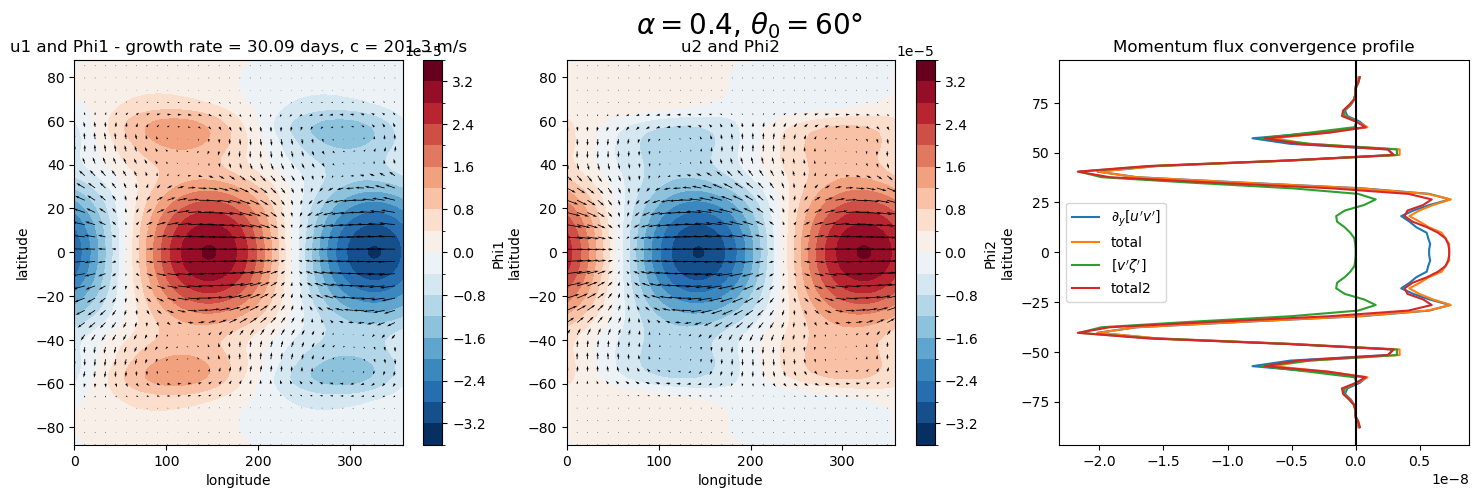

In [29]:
_,axss = plt.subplots(m_max,3,figsize = (18,m_max*5))
axss=(axss,)
for i,(axs,mode) in enumerate(zip(axss,modes)):
    plot_one_theta_wind(axs[0],np.real(mode.Phi1),np.real(mode.u1),vmin=None,vmax=None,wind_disc=2,cmap=plt.cm.RdBu_r)
    plot_one_theta_wind(axs[1],np.real(mode.Phi2),np.real(mode.u2),vmin=None,vmax=None,wind_disc=2,cmap=plt.cm.RdBu_r)
    emfc_hz,emfc_tot,vzeta,emfc_tot2 = emfc(np.real(mode))
    emfc_hz .plot(ax=axs[2],y='latitude',label=r"$\partial_y[u'v']$")
    emfc_tot.plot(ax=axs[2],y='latitude',label='total')
    vzeta .plot(ax=axs[2],y='latitude',label=r"$[v'\zeta']$")
    emfc_tot2.plot(ax=axs[2],y='latitude',label='total2')
    #(2*Omega*np.sin(mode.latitude*np.pi/180)*np.abs(mode.u1[1])).mean('longitude').plot(ax=axs[2],y='latitude',label='fv')
    #np.sqrt((mode.hyperdiff_u1**2).mean('longitude')).plot(ax=axs[2],y='latitude',label='hyperdiffusion')
    axs[2].axvline(0.,color='k'); axs[2].legend()
    axs[0].set_title('u1 and Phi1 - growth rate = %.2f days, c = %.1f m/s'%(1/(growth_rates[i]*day),phasespeeds[i]/(meter/second)))
    axs[1].set_title('u2 and Phi2')
    axs[2].set_title('Momentum flux convergence profile')
plt.suptitle(r"$\alpha=0.4$, $\theta_0 = 60$°",fontsize=20)

Text(0.5, 0.98, '$\\alpha=0.4$, $\\theta_0 = 60$°')

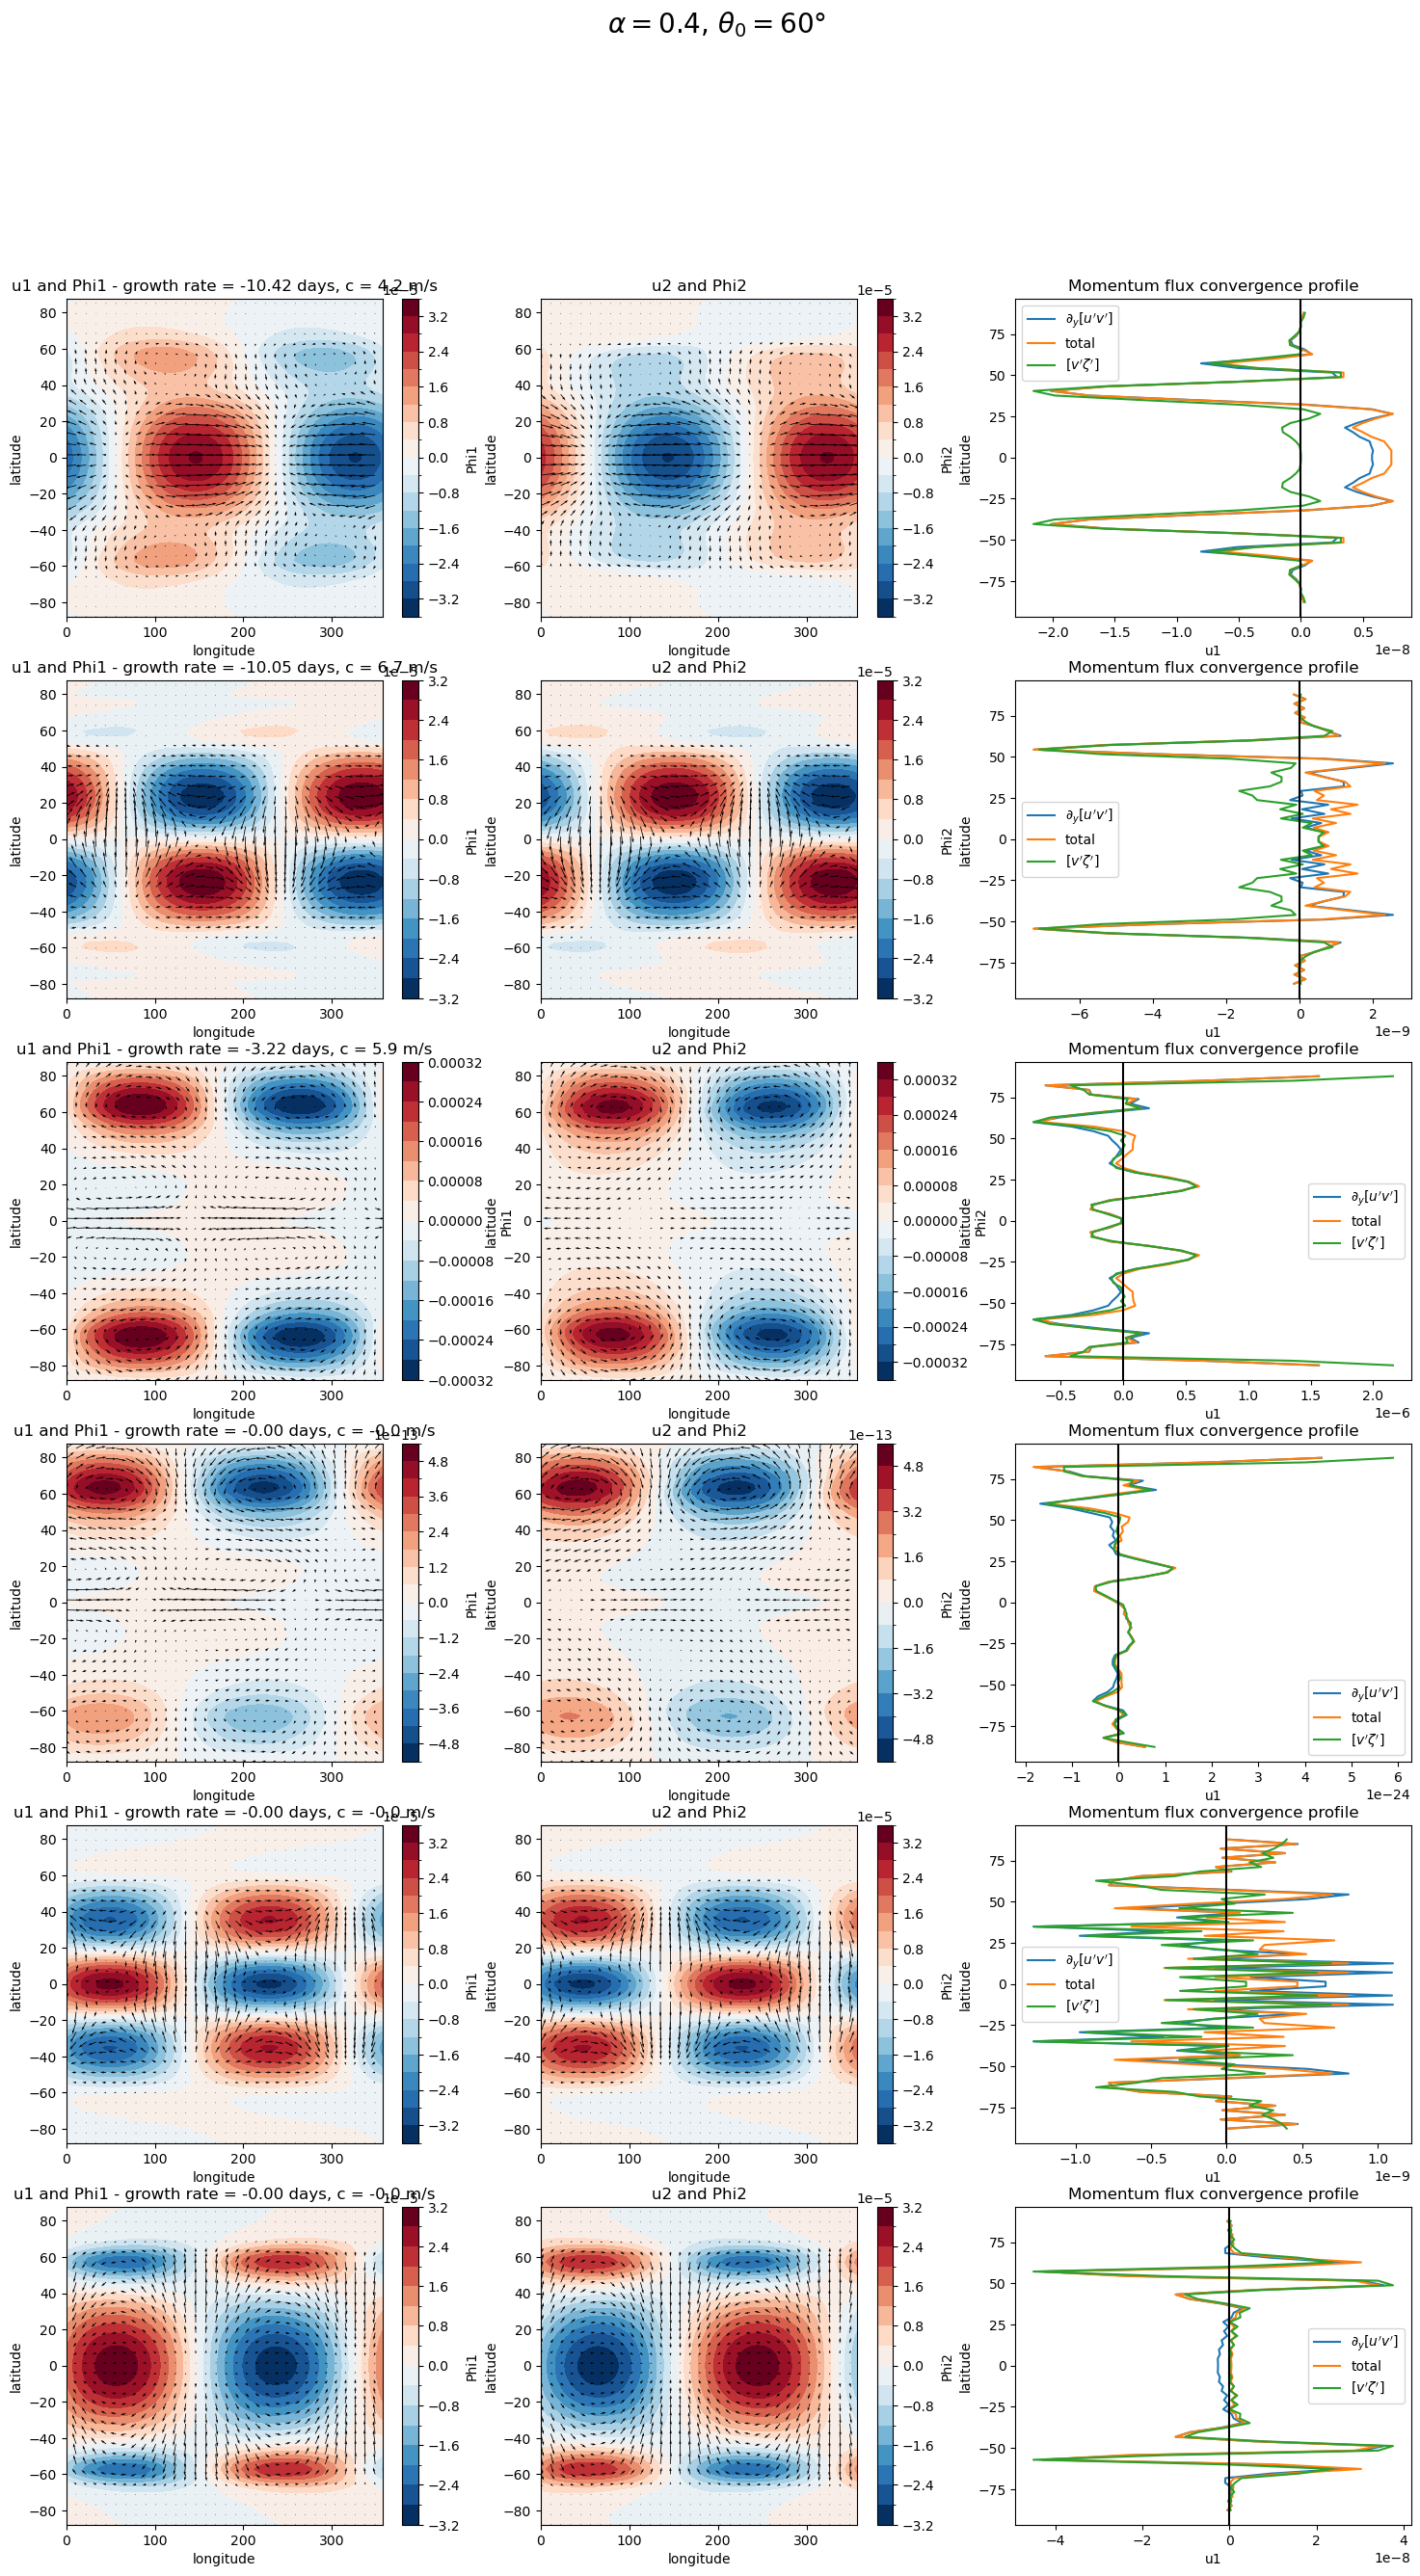

In [32]:
_,axss = plt.subplots(n_max,3,figsize = (18,n_max*5))
#axss=(axss,)
for i,(axs,mode) in enumerate(zip(axss,modes)):
    plot_one_theta_wind(axs[0],np.real(mode.Phi1),np.real(mode.u1),vmin=None,vmax=None,wind_disc=2,cmap=plt.cm.RdBu_r)
    plot_one_theta_wind(axs[1],np.real(mode.Phi2),np.real(mode.u2),vmin=None,vmax=None,wind_disc=2,cmap=plt.cm.RdBu_r)
    emfc_hz,emfc_tot,vzeta,_ = emfc(np.real(mode))
    emfc_hz .plot(ax=axs[2],y='latitude',label=r"$\partial_y[u'v']$")
    emfc_tot.plot(ax=axs[2],y='latitude',label='total')
    vzeta .plot(ax=axs[2],y='latitude',label=r"$[v'\zeta']$")
    axs[2].axvline(0.,color='k'); axs[2].legend()
    axs[0].set_title('u1 and Phi1 - growth rate = %.2f days, c = %.1f m/s'%(1/(growth_rates[i]*day),phasespeeds[i]/(meter/second)))
    axs[1].set_title('u2 and Phi2')
    axs[2].set_title('Momentum flux convergence profile')
plt.suptitle(r"$\alpha=0.4$, $\theta_0 = 60$°",fontsize=20)

Text(0.5, 0.98, '$\\alpha=0.$, $\\theta_0 = 50$°')

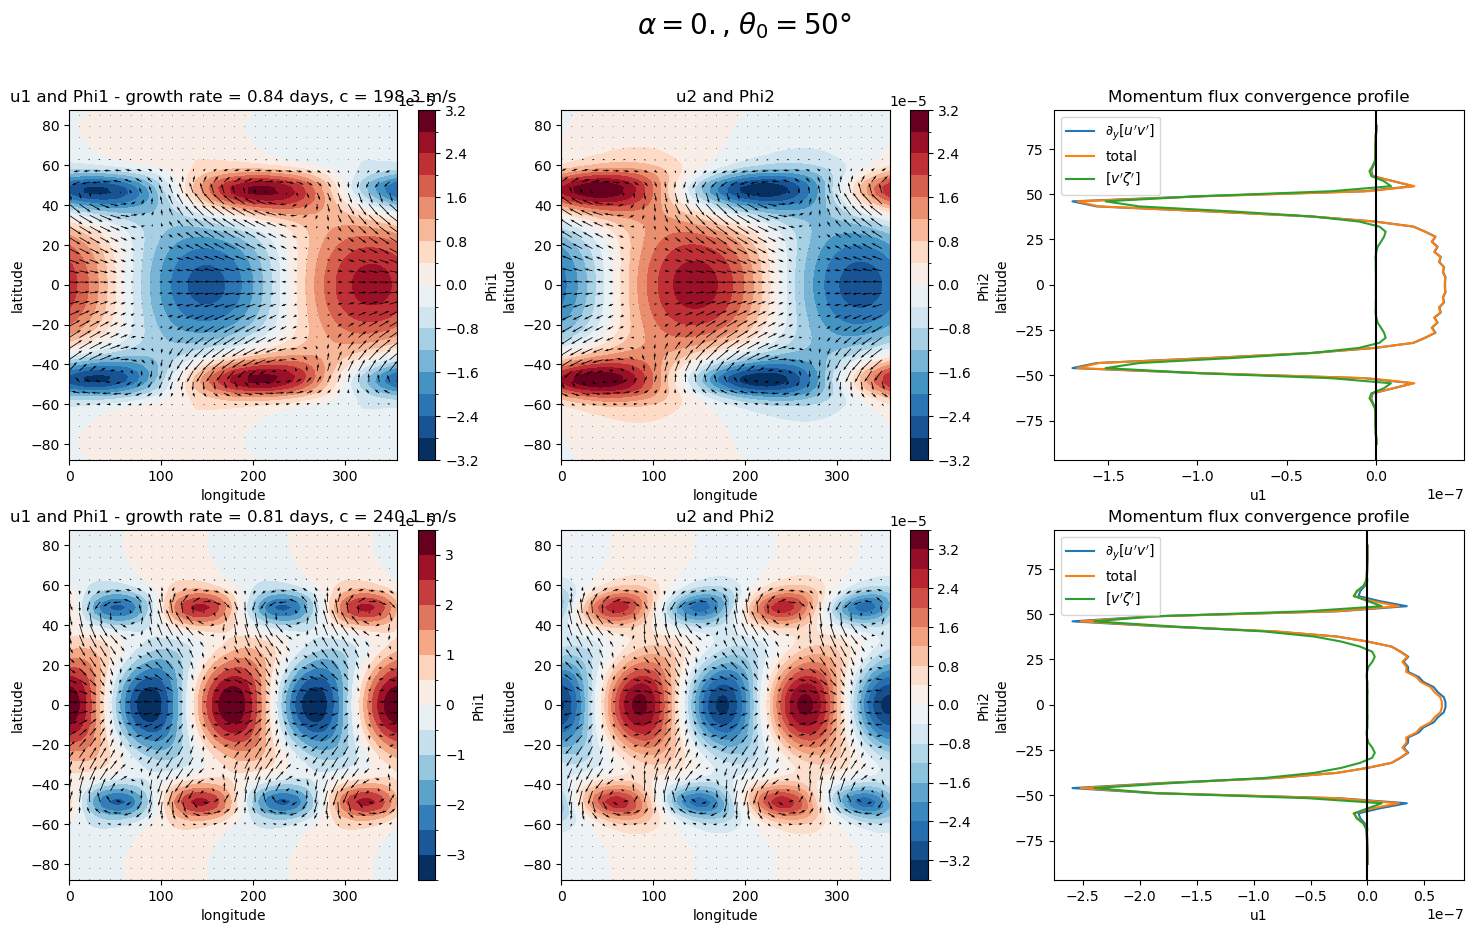

In [36]:
_,axss = plt.subplots(m_max,3,figsize = (18,m_max*5))
#axss=(axss,)
for i,(axs,mode) in enumerate(zip(axss,modes)):
    plot_one_theta_wind(axs[0],np.real(mode.Phi1),np.real(mode.u1),vmin=None,vmax=None,wind_disc=2,cmap=plt.cm.RdBu_r)
    plot_one_theta_wind(axs[1],np.real(mode.Phi2),np.real(mode.u2),vmin=None,vmax=None,wind_disc=2,cmap=plt.cm.RdBu_r)
    emfc_hz,emfc_tot,vzeta,_ = emfc(np.real(mode))
    emfc_hz .plot(ax=axs[2],y='latitude',label=r"$\partial_y[u'v']$")
    emfc_tot.plot(ax=axs[2],y='latitude',label='total')
    vzeta .plot(ax=axs[2],y='latitude',label=r"$[v'\zeta']$")
    axs[2].axvline(0.,color='k'); axs[2].legend()
    axs[0].set_title('u1 and Phi1 - growth rate = %.2f days, c = %.1f m/s'%(1/(growth_rates[i]*day),phasespeeds[i]/(meter/second)))
    axs[1].set_title('u2 and Phi2')
    axs[2].set_title('Momentum flux convergence profile')
plt.suptitle(r"$\alpha=0.$, $\theta_0 = 50$°",fontsize=20)

In [11]:
import matplotlib

In [19]:
def plot_one_theta_wind(ax,theta,wind,vmin=300,vmax=370,levels=18,cmap = plt.cm.viridis,scale=None,wind_disc=1,include_qk=False,qk_scale=100,cbar_kwargs={}):
        (theta).plot.contourf(ax=ax,y='latitude',levels=levels,cmap=cmap,vmin=vmin,vmax=vmax,cbar_kwargs=cbar_kwargs)
        n=2*wind_disc;m=wind_disc
        q=ax.quiver(wind.longitude[::n],
                  wind.latitude[::m] ,
                  wind[0][::n,::m].T ,
                  -wind[1][::n,::m].T,
                  scale=scale)
        if include_qk:
            ax.quiverkey(q, 1.05, -0.05, qk_scale, r'%i m s$^{-1}$'%qk_scale, labelpos='N',coordinates='axes',color='k')
        

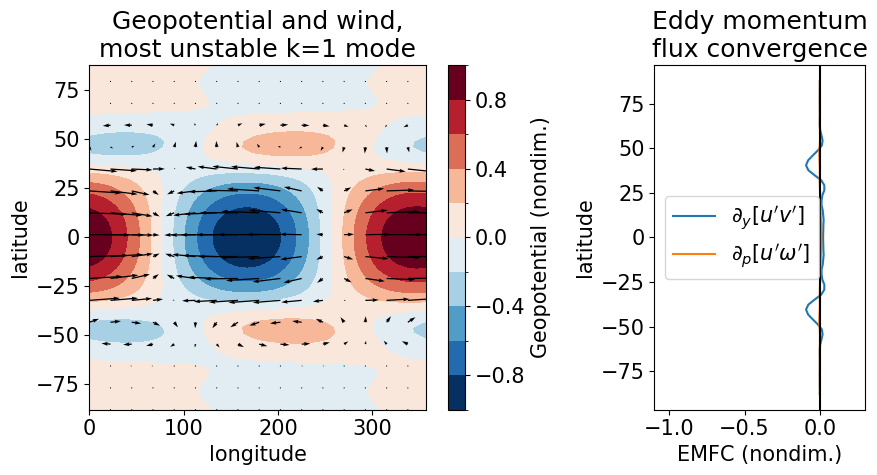

In [104]:
matplotlib.rcParams.update({'font.size':15})
fig,axs = plt.subplots(1,2,figsize = (9,5),width_ratios=[2,1])
#axss=(axss,)
mode = modes[0]
plot_one_theta_wind(axs[0],np.real(mode.Phi1)/np.real(mode.Phi1).max(),np.real(mode.u1),vmin=None,vmax=None,levels=11,wind_disc=4,cmap=plt.cm.RdBu_r,cbar_kwargs={'label':'Geopotential (nondim.)'})
#emfc_hz,emfc_tot,vzeta,_ = emfc(np.real(mode),R)
(emfc_hz/1.7e-7) .plot(ax=axs[1],y='latitude',label=r"$\partial_y[u'v']$")
((emfc_tot-emfc_hz)/1.7e-7).plot(ax=axs[1],y='latitude',label=r"$\partial_p[u'\omega']$")
axs[1].axvline(0.,color='k'); axs[1].legend()
axs[0].set_title('Geopotential and wind,\nmost unstable k=1 mode')
axs[1].set_title('Eddy momentum\nflux convergence')
axs[1].set_xlabel('EMFC (nondim.)')
axs[1].set_xlim(-1.1,0.3)
fig.tight_layout()

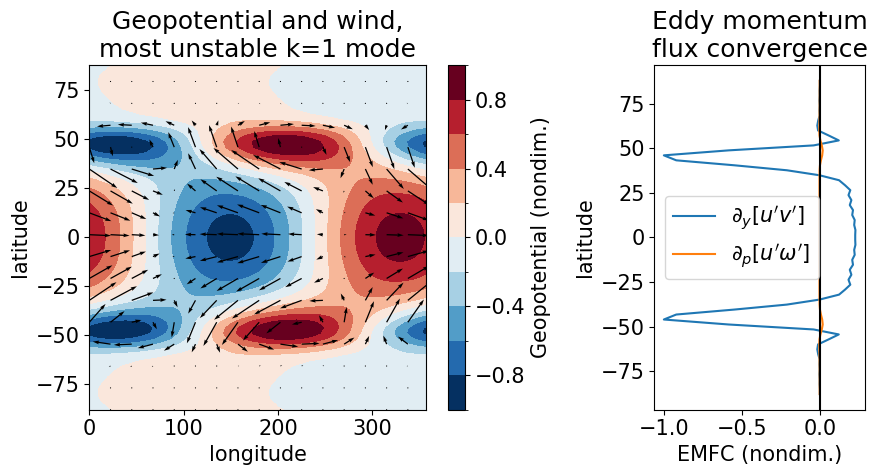

In [92]:
matplotlib.rcParams.update({'font.size':15})
fig,axs = plt.subplots(1,2,figsize = (9,5),width_ratios=[2,1])
#axss=(axss,)
mode = modes[0]
plot_one_theta_wind(axs[0],np.real(mode.Phi1)/np.real(mode.Phi1).max(),np.real(mode.u1),vmin=None,vmax=None,levels=11,wind_disc=4,cmap=plt.cm.RdBu_r,cbar_kwargs={'label':'Geopotential (nondim.)'})
emfc_hz,emfc_tot,vzeta,_ = emfc(np.real(mode),R)
(emfc_hz/(-emfc_hz.min())) .plot(ax=axs[1],y='latitude',label=r"$\partial_y[u'v']$")
((emfc_tot-emfc_hz)/(-emfc_hz.min())).plot(ax=axs[1],y='latitude',label=r"$\partial_p[u'\omega']$")
axs[1].axvline(0.,color='k'); axs[1].legend()
axs[0].set_title('Geopotential and wind,\nmost unstable k=1 mode')
axs[1].set_title('Eddy momentum\nflux convergence')
axs[1].set_xlabel('EMFC (nondim.)')
fig.tight_layout()

In [93]:
(-emfc_hz.min())

<xarray.DataArray 'u1' ()>
array(1.70060835e-07)